In [1]:
from pygtrie import Trie, StringTrie

In [2]:
st = StringTrie()
st

StringTrie([], separator='/')

In [3]:
st['dog'] = 1
st['dog/cat'] = 2
st['monkey'] = 3
st

StringTrie([('dog', 1), ('dog/cat', 2), ('monkey', 3)], separator='/')

In [7]:
st.longest_prefix('dog/cat')

('dog/cat': 2)

In [8]:
st.longest_prefix('dog')

('dog': 1)

## My version

In [870]:
from copy import deepcopy
from functools import partial

from htools import *
from lolviz import *

In [1089]:
class TrieNode:
    
    def __init__(self, data=()):
        self.edges = {}
        self.stop_state = False
        for x in data:
            self.append(x)
        
    def append(self, seq):
        if not seq: 
            self.stop_state = True
            return
        x = seq[0]
        if x not in self.edges:
            self.edges[x] = TrieNode()
        self.edges[x].append(seq[1:])
        
    def __repr__(self):
        return f'{type(self).__name__}({list(self.edges.keys()) or ""})'

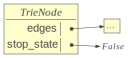

In [1090]:
node = TrieNode()
objviz(node)

In [1091]:
node

TrieNode()

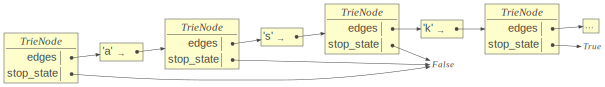

In [1092]:
node.append('ask')
objviz(node)

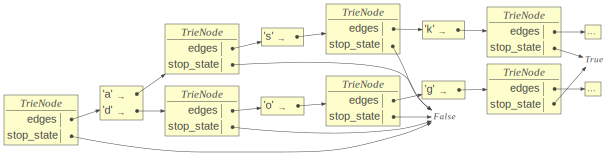

In [1093]:
node.append('dog')
objviz(node)

In [1094]:
node

TrieNode(['a', 'd'])

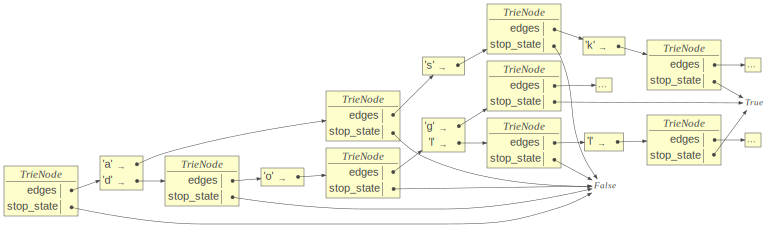

In [1095]:
node.append('doll')
objviz(node)

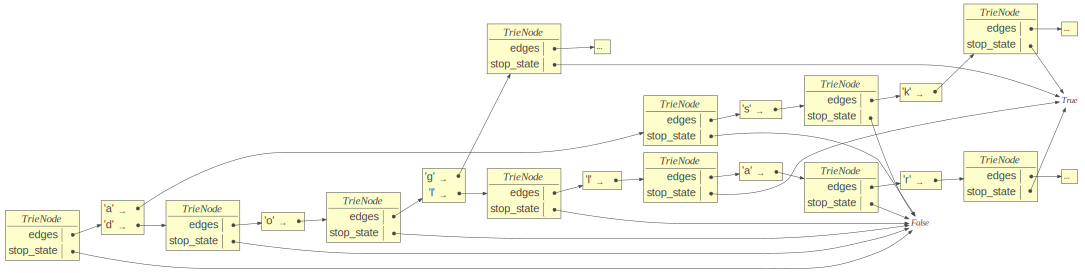

In [1096]:
node.append('dollar')
objviz(node)

In [1097]:
TrieNode(['dog', 'cat'])

TrieNode(['d', 'c'])

In [1098]:
x = 6
type([]).__name__

'list'

In [1672]:
class Trie:
    
    def __init__(self, data=(), suffix=False):
        """
        Parameters
        ----------
        data: str or list-like Iterable
            If provided, this should be one or more sequences to add to the
            try. Sequences could be strings, lists of strings (like word
            tokens), tuples of integers, etc. As of Dec 2020, this should NOT
            be numpy arrays or torch tensors.
        """
        self.head = TrieNode()
        if suffix:
            self._maybe_reverse = lambda x: x[::-1]
        else:
            self._maybe_reverse = identity
        self.suffix = suffix
            
        # dtype records the type of object present in the trie, and is a
        # string rather than a type because lolviz library has a
        # bug when displaying type attributes. Its visualizations are very
        # helpful here so I don't want to break compatibility.
        self.dtype = ''
        self.child_dtype = ''
        self.postprocess = None
        for item in tolist(data):
            self.append(item)
        
    def append(self, seq):
        """Add a sequence to the trie. This operates in place."""
        if not self.postprocess: 
            self.dtype = type(seq).__name__
            self.child_dtype = type(seq[0]).__name__
            self.postprocess = partial(str.join, '') if self.dtype == 'str' \
                else identity
        else:
            self._validate_input(seq)
        self.head.append(self._maybe_reverse(seq))
        
    def extend(self, seqs):
        for seq in seqs:
            self.append(seq)
            
    def __add__(self, seq):
        """Allows us to add items to a trie using + operator. This does not 
        alter the trie in place: to do that, use `append` or assign the result
        of this method back to your variable.
        
        Returns
        -------
        Trie
        """
        clone = deepcopy(self)
        clone.append(seq)
        return clone
    
    def _find(self, seq, node=None, reverse_if_necessary=True):
        """Try to find a a sequence in the trie. We provide this helper method
        rather than doing it entirely in __contains__ in case other methods
        want to make use of the found node (perhaps passing it to 
        self._values.)
        
        Returns
        -------
        TrieNode: If node.stop_state=True, the seq is in the trie. If False,
        it's not.
        """
        self._validate_input(seq)
        if reverse_if_necessary: seq = self._maybe_reverse(seq)
        node = node or self.head
        for x in seq:
            if x not in node.edges: return TrieNode()
            node = node.edges[x]
        return node
    
    def __contains__(self, seq):
        """Check if a sequence is present in the trie.
        
        Returns
        -------
        bool
        """
        return self._find(seq).stop_state
    
    def _values(self, seen, current, node=None):
        """Traverse all values starting from a given node and return them as a
        list. If a node is not explicitly provided, the head will be used and
        all values in the trie will be retrieved.
        """
        node = node or self.head
        if node.stop_state:
            # Here, reversal is more of a postprocessing step than a 
            # preprocessing one: we're converting the reversed word stored in
            # the suffix tree back to its original order.
            seen.append(self._maybe_reverse(self.postprocess(current)))
        if not node.edges: return []
        for key, node_ in node.edges.items():
            self._values(seen, current+[key], node_)
        return seen
    
    def values(self):
        """Wrapper for _values for when we want all values in the trie.
        Seems that we need to explicitly pass in lists for `seen` and
        `current` for some reason, otherwise we get an empty result.
        """
        return self._values([], [])
    
    def _startswith(self, seq, node=None):
        node = self._find(seq, node=node)
        if self.suffix: 
            return [x + seq for x in self._values([], [], node)]
        else:
            return [seq + x for x in self._values([], [], node)]
    
    def startswith(self, seq, node=None):
        if self.suffix:
            warnings.warn(
                'Suffix trees are optimized for the `endswith` method, but '
                '`startswith` will require walking the whole trie (may be '
                'slow and memory intensive). For an efficient implementation '
                'of `startswithwith`, you can create a prefix tree by '
                ' passing `suffix=False` to Trie.__init__.'
            )
            if self.dtype == 'str':
                return [v for v in self.values() if v.startswith(seq)]
            else:
                self._validate_input(seq)
                length = len(seq)
                return [v for v in self.values() if v[:length] == seq]
        return self._startswith(seq, node=node)
    
    def endswith(self, seq, node=None):
        if not self.suffix:
            warnings.warn(
                'Prefix trees are optimized for the `startswith` method, but '
                '`endswith` will require walking the whole trie (may be '
                'slow and memory intensive). For an efficient implementation '
                'of `endswith`, you can create a suffix tree by passing '
                '`suffix=True` to Trie.__init__.'
            )
            if self.dtype == 'str':
                return [v for v in self.values() if v.endswith(seq)]
            else:
                self._validate_input(seq)
                length = len(seq)
                return [v for v in self.values() if v[-length:] == seq]
        return self._startswith(seq, node=node)
    
    def _longest_matching_prefix(self, seq, seen):
        matches = self.startswith(seq)
        if matches: return matches
        node = self.head
        for i, x in enumerate(seq):
            if x in node.edges:
                seen.append(x)
                node = node.edges[x]
            elif i == 0:
                # Otherwise, all values are returned when the first item is 
                # not in the trie.
                return []
            else:
                return [self.postprocess(seen + [v]) 
                        for v in self._values([], [], node)]
            
    def longest_matching_prefix(self, seq):
        # Validation occurs in self.startswith, often via self._find.
        return self._longest_matching_prefix(seq, [])
    
    def _validate_input(self, seq):
        """This should occur before calling self._maybe_reverse."""
        if type(seq).__name__ != self.dtype:
            raise TypeError('`seq` type doesn\'t match type of other '
                            'sequences.')
        if type(seq[0]).__name__ != self.child_dtype:
            raise TypeError('Type of first item in `seq` doesn\'t match type '
                            'of first item in other sequences.')
    
    # TODO: wishlist
    """
    -version of _values() that traverses the tree as a generator, perhaps as
        __iter__. This would
        let us easily apply logic at each step and avoids walking the whole 
        subtrie unless that's what we really want.
    -some sort of distance(seq1, seq2) method
    -typos/neighbors (see Terence's slides)
        -longest matching prefix/suffix
    -let user pass in kv pair (e.g. could use this as a w2i dict). However,
    I think this might require a dramatically different interface. Or could I
    just make it so that we only use this functionality if you pass in a dict
    or list of dicts? Prob much slower than a dict so I don't know if we'd
    actually want to use it in that case. Passing in a dict might also be
    problematic for my reversal function and type checking.
    """

In [1654]:
t = Trie(['dolphin', 'deer'], suffix=False)

In [1655]:
t.append('star')
t.append('study')
t.append('apple')
t.append('larkin')
t.append('app')
t.append('castle')
t.append('lake')
t.append('cake')

In [1656]:
t.values()

['dolphin',
 'deer',
 'star',
 'study',
 'app',
 'apple',
 'larkin',
 'lake',
 'castle',
 'cake']

In [1657]:
assert 'app' in t
assert 'apple' in t
assert 'ap' not in t
assert 'appleton' not in t
assert 'fox' not in t

In [1658]:
tmp = t + 'candy'
assert 'candy' in tmp
assert not 'candy' in t

In [1659]:
t += 'car'
t += 'stunning'
t += 'stir'
t += 'sorry'

In [1660]:
t.extend(['sturdy', 'stipend', 'cold'])

In [1661]:
t.startswith('stu')

['study', 'stunning', 'sturdy']

In [1662]:
t.startswith('ap')

['app', 'apple']

In [1663]:
t.startswith('ca')

['castle', 'cake', 'car']

In [1664]:
t.startswith('zzz')

[]

In [1665]:
t.endswith('ke')

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: Prefix trees are optimized for the `startswith` method, but `endswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


['lake', 'cake']

In [1666]:
with assert_raises(TypeError):
    t.startswith(['n'])

As expected, got TypeError(`seq` type doesn't match type of other sequences.).


In [1667]:
with assert_raises(TypeError):
    t += ['a', 'b']

As expected, got TypeError(`seq` type doesn't match type of other sequences.).


In [1668]:
t.values()

['dolphin',
 'deer',
 'star',
 'study',
 'stunning',
 'sturdy',
 'stir',
 'stipend',
 'sorry',
 'app',
 'apple',
 'larkin',
 'lake',
 'castle',
 'cake',
 'car',
 'cold']

In [1669]:
t.longest_matching_prefix('applicable')

['apple']

In [1670]:
t.longest_matching_prefix('candid')

['castle', 'cake', 'car']

In [1671]:
t.longest_matching_prefix('zoo')

[]

In [1632]:
def longest_matching_prefix(self, seq, seen):
    matches = self.startswith(seq)
    if matches: return matches
    node = self.head
    for x in seq:
#         print(x)
        if x in node.edges:
#             print('found', x)
            seen.append(x)
            node = node.edges[x]
        else:
#             print('not in edges', x)
            return [self.postprocess(seen + [v]) for v in self._values([], [], node)]

In [1630]:
longest_matching_prefix(t, 'castigate', [])

found c
found a
found s
found t
not in edges i


['castle']

In [1631]:
longest_matching_prefix(t, 'cannon', [])

found c
found a
not in edges n


['castle', 'cake', 'car']

In [1565]:
def walk(node, seen, current):
    if node.stop_state: seen.append(''.join(current))
    if not node.edges: return
    for key, node_ in node.edges.items():
        walk(node_, seen, current+[key])
    return seen

In [1566]:
def startswith(node, seq):
    for i, x in enumerate(seq):
        print(i, x)
        if x not in node.edges: return False
        node = node.edges[x]
    return walk(node, [], list(seq))

In [1567]:
t2 = Trie()
t2.append(['I',  'went', 'to', 'school', 'today', '.'])
t2.append(['I',  'like', 'horses', '.'])
t2.append(['He', 'is', 'home', 'early', '.'])
t2.append(['I', 'went', 'to', 'the', 'beach', '.'])

In [1568]:
t2.values()

[['I', 'went', 'to', 'school', 'today', '.'],
 ['I', 'went', 'to', 'the', 'beach', '.'],
 ['I', 'like', 'horses', '.'],
 ['He', 'is', 'home', 'early', '.']]

In [1569]:
t2.startswith(['I'])

[['I', 'went', 'to', 'school', 'today', '.'],
 ['I', 'went', 'to', 'the', 'beach', '.'],
 ['I', 'like', 'horses', '.']]

In [1570]:
t2.endswith(['today', '.'])

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:163: UserWarning: Prefix trees are optimized for the `startswith` method, but `endswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


[['I', 'went', 'to', 'school', 'today', '.']]

In [1571]:
t2.endswith(['.'])

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:163: UserWarning: Prefix trees are optimized for the `startswith` method, but `endswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


[['I', 'went', 'to', 'school', 'today', '.'],
 ['I', 'went', 'to', 'the', 'beach', '.'],
 ['I', 'like', 'horses', '.'],
 ['He', 'is', 'home', 'early', '.']]

In [1572]:
t2.extend([['Hot', 'chocolate'], ['sandy', 'beach']])

In [1573]:
with assert_raises(TypeError):
    t2.startswith('h')

As expected, got TypeError(`seq` type doesn't match type of other sequences.).


In [1574]:
with assert_raises(TypeError):
    t2 += (3, 4)

As expected, got TypeError(`seq` type doesn't match type of other sequences.).


In [1575]:
with assert_raises(TypeError):
    t2.append([1, 2, 3])

As expected, got TypeError(Type of first item in `seq` doesn't match type of first item in other sequences.).


In [1576]:
ex = [
    'It is cold and windy.',
    'The food was still hot.',
    'It is not warm.',
    'The cow mooed loudly.',
    'It is cold and snowy.'
]

t3 = Trie()
for e in ex:
    item = list(map(tuple, ngrams(e.split(), 2, 2, False)))
    print(item)
    t3.append(item)

[('It', 'is'), ('cold', 'and'), ('windy.',)]
[('The', 'food'), ('was', 'still'), ('hot.',)]
[('It', 'is'), ('not', 'warm.')]
[('The', 'cow'), ('mooed', 'loudly.')]
[('It', 'is'), ('cold', 'and'), ('snowy.',)]


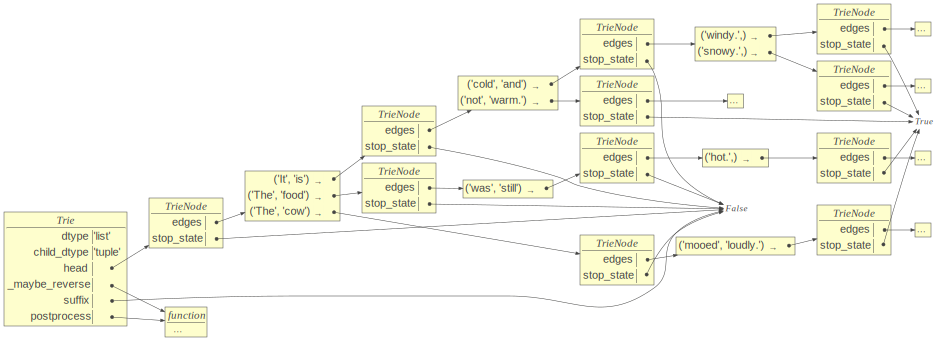

In [1577]:
objviz(t3)

In [1578]:
t3.values()

[[('It', 'is'), ('cold', 'and'), ('windy.',)],
 [('It', 'is'), ('cold', 'and'), ('snowy.',)],
 [('It', 'is'), ('not', 'warm.')],
 [('The', 'food'), ('was', 'still'), ('hot.',)],
 [('The', 'cow'), ('mooed', 'loudly.')]]

In [1579]:
with assert_raises(TypeError):
    t3.append(('It', 'is'))

As expected, got TypeError(`seq` type doesn't match type of other sequences.).


In [1580]:
with assert_raises(TypeError):
    t3.append(['It', 'is'])

As expected, got TypeError(Type of first item in `seq` doesn't match type of first item in other sequences.).


In [1581]:
t3.append([('It', 'is')])
t3.startswith([('It', 'is')])

[[('It', 'is')],
 [('It', 'is'), ('cold', 'and'), ('windy.',)],
 [('It', 'is'), ('cold', 'and'), ('snowy.',)],
 [('It', 'is'), ('not', 'warm.')]]

In [1582]:
t3.startswith([('It', 'is'), ('cold', 'and')])

[[('It', 'is'), ('cold', 'and'), ('windy.',)],
 [('It', 'is'), ('cold', 'and'), ('snowy.',)]]

In [1583]:
with assert_raises(TypeError):
    t3.startswith(['It', 'is', 'cold', 'and'])

As expected, got TypeError(Type of first item in `seq` doesn't match type of first item in other sequences.).


In [1584]:
t3.endswith([('mooed', 'loudly.')])

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:163: UserWarning: Prefix trees are optimized for the `startswith` method, but `endswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


[[('The', 'cow'), ('mooed', 'loudly.')]]

In [1585]:
t3.endswith([('mooed',)])

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:163: UserWarning: Prefix trees are optimized for the `startswith` method, but `endswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `endswith`, you can create a suffix tree by passing `suffix=True` to Trie.__init__.


[]

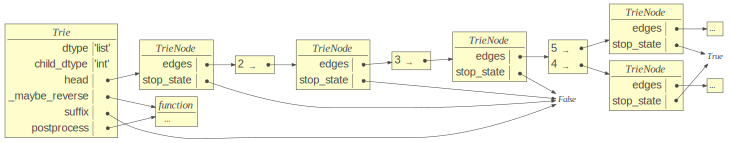

In [1586]:
t5 = Trie([[2, 3, 5], [2, 3, 4]])
objviz(t5)

In [1587]:
t5.startswith([2])

[[2, 3, 5], [2, 3, 4]]

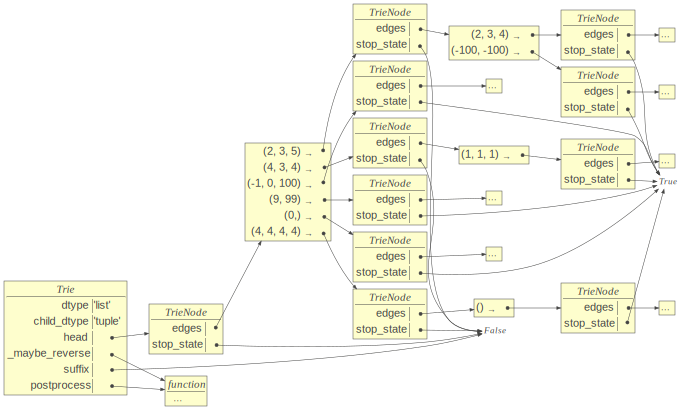

In [1588]:
t6 = Trie([[(2, 3, 5), (2, 3, 4)]])
t6.append([(4, 3, 4), (1, 1, 1)])
t6.extend([[(-1, 0, 100)], [(9, 99)]])
t6 += [(0,)]
t6 = t6 + [(4, 4, 4, 4), ()]
t6.append([(2, 3, 5), (-100, -100)])
objviz(t6)

In [1589]:
t6.startswith([(2, 3, 5)])

[[(2, 3, 5), (2, 3, 4)], [(2, 3, 5), (-100, -100)]]

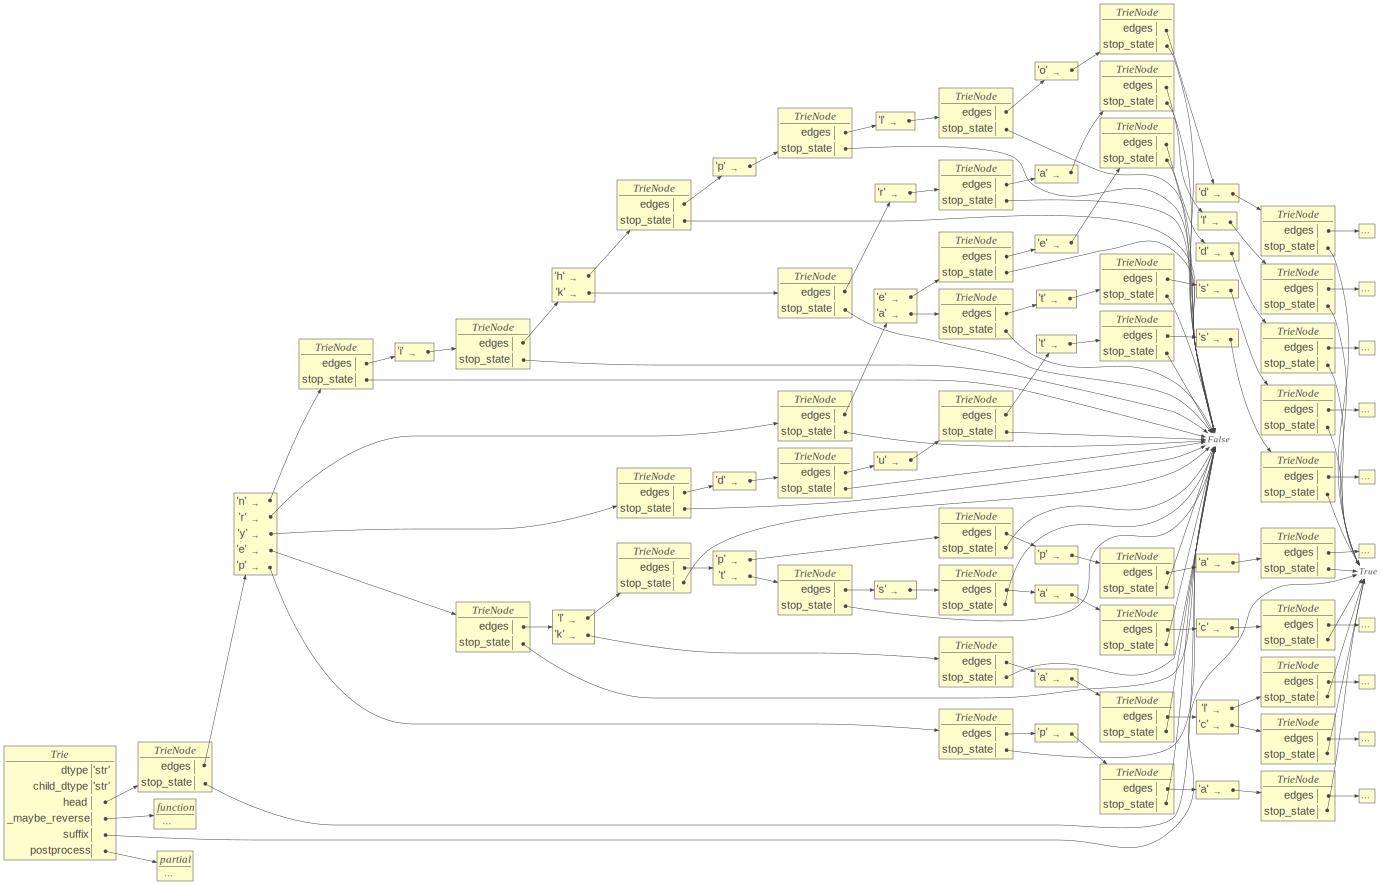

In [1590]:
t7 = Trie(['dolphin', 'deer'], suffix=True)
t7.append('star')
t7 += 'study'
t7 = t7 + 'apple'
t7.extend(['larkin', 'app'])
t7.append('castle')
t7.append('lake')
t7.append('cake')

objviz(t7)

In [1591]:
assert all(term in t7 
           for term in ('dolphin', 'star', 'study', 'apple', 'larkin', 'app'))
assert 'zebra' not in t7
assert 'dolphin'[::-1] not in t7

In [1592]:
t7.startswith('ap')

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: Suffix trees are optimized for the `endswith` method, but `startswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `startswithwith`, you can create a prefix tree by  passing `suffix=False` to Trie.__init__.


['apple', 'app']

In [1593]:
t7.endswith('in')

['dolphin', 'larkin']

In [1594]:
t7.startswith('ni')

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: Suffix trees are optimized for the `endswith` method, but `startswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `startswithwith`, you can create a prefix tree by  passing `suffix=False` to Trie.__init__.


[]

In [1595]:
t8 = Trie(suffix=True)
t8.append(['I',  'went', 'to', 'school', 'today', '.'])
t8.append(['I',  'like', 'horses', '.'])
t8.append(['He', 'is', 'home', 'early', '.'])
t8.append(['I', 'went', 'to', 'the', 'beach', '.'])

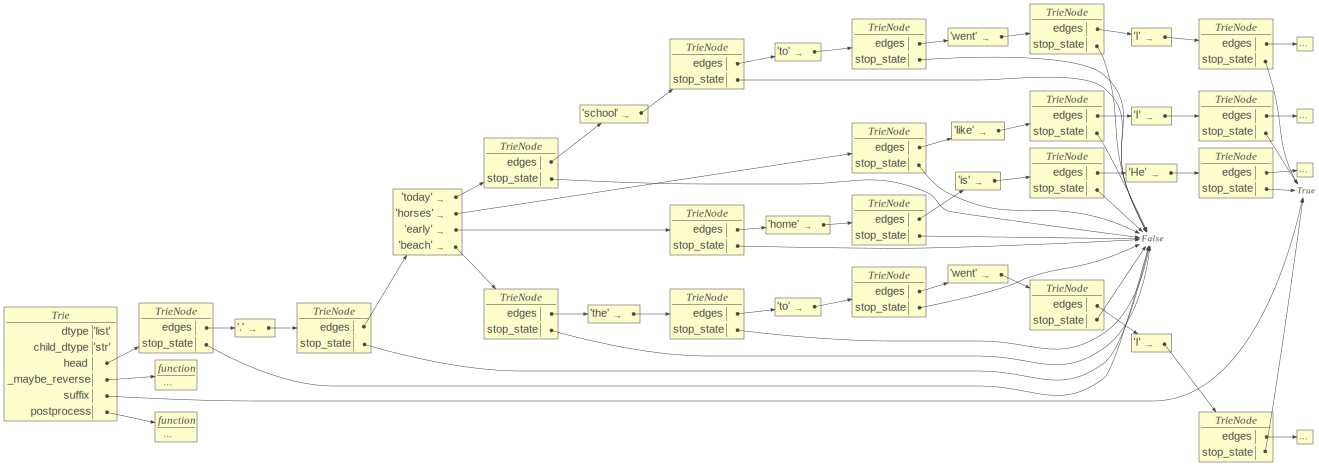

In [1596]:
objviz(t8)

In [1597]:
t8.values()

[['I', 'went', 'to', 'school', 'today', '.'],
 ['I', 'like', 'horses', '.'],
 ['He', 'is', 'home', 'early', '.'],
 ['I', 'went', 'to', 'the', 'beach', '.']]

In [1598]:
t8.startswith(['I', 'went'])

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: Suffix trees are optimized for the `endswith` method, but `startswith` will require walking the whole trie (may be slow and memory intensive). For an efficient implementation of `startswithwith`, you can create a prefix tree by  passing `suffix=False` to Trie.__init__.


[['I', 'went', 'to', 'school', 'today', '.'],
 ['I', 'went', 'to', 'the', 'beach', '.']]

In [1599]:
t8.endswith(['like', 'horses', '.'])

[['I', 'like', 'horses', '.']]

In [1600]:
t8.endswith(['I'])

[]